<a href="https://colab.research.google.com/github/sereliezer/sereliezer.github.io/blob/master/content/teaching/deeplearning-ufc-2025/ipynb/aula2_unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 2 - Exemplo: PCA com Regra de Oja e Autoencoder Linear

**Objetivo:** Implementar e comparar três métodos para encontrar o primeiro componente principal de um subconjunto de dados do MNIST (dígitos 9 e 1).

---

Neste exemplo, vamos conectar a teoria com a prática, explorando três visões diferentes do mesmo problema fundamental: encontrar a direção de máxima variância em um conjunto de dados. Usaremos:

1.  **PCA (Scikit-learn):** A abordagem estatística clássica, que nos servirá como "ground truth".
2.  **Regra de Oja (NumPy):** Uma regra de aprendizado neural, não-supervisionada e biologicamente inspirada.
3.  **Autoencoder Linear (PyTorch):** Uma abordagem de aprendizado de representação baseada na otimização de um custo de reconstrução.

Vamos ver como essas três perspectivas diferentes nos levam à mesma solução!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from sklearn.decomposition import PCA

# Configurações de estilo para os gráficos
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'font.size': 14})

## Passo 1: Carregamento e Preparação dos Dados

Primeiro, vamos carregar o dataset MNIST, filtrar para manter apenas os dígitos 0 e 1, e pré-processá-los.

In [ ]:
# Carregar o dataset MNIST
train_data = MNIST(root='./data', train=True, download=True, transform=ToTensor())

# Filtrar para manter apenas os dígitos 0 e 1
mask = (train_data.targets == 9) | (train_data.targets == 1)
data = train_data.data[mask].float() / 255.0  # Normalizar para [0, 1]
labels = train_data.targets[mask]

# Flatten das imagens (28x28 -> 784)
data_flat = data.reshape(-1, 28 * 28)

# Centralizar os dados (crucial para PCA)
mean = data_flat.mean(axis=0)
data_centered = data_flat - mean

print(f"Formato dos dados: {data_centered.shape}")
print(f"Número de amostras: {len(data_centered)}")

100%|██████████| 9.91M/9.91M [00:00<00:00, 55.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.68MB/s]

Formato dos dados: torch.Size([12691, 784])
Número de amostras: 12691


## Método 1: PCA com Scikit-learn (Ground Truth)

Vamos usar a implementação padrão do PCA para encontrar o primeiro componente principal. Este será nosso resultado de referência.

In [ ]:
pca = PCA(n_components=1)
pca.fit(data_centered.numpy())

pc1_sklearn = pca.components_[0]
print(f"Formato do componente principal (Sklearn): {pc1_sklearn.shape}")

Formato do componente principal (Sklearn): (784,)


## Método 2: Regra de Oja (NumPy)

Agora, vamos implementar a regra de Oja do zero. A regra de atualização é:
$$ \Delta \mathbf{w} = \eta (y\mathbf{x} - y^2\mathbf{w}) $$
Onde $y = \mathbf{w}^T\mathbf{x}$.

In [ ]:
# Hiperparâmetros
learning_rate_oja = 1e-4
epochs_oja = 5

# Inicialização dos pesos
np.random.seed(42)
w_oja = np.random.randn(784)
w_oja = w_oja / np.linalg.norm(w_oja) # Normalizar para ter norma 1

data_numpy = data_centered.numpy()

# Loop de Treinamento
for epoch in range(epochs_oja):
    for x in data_numpy:
        # Calcular a saída
        y = np.dot(w_oja.T, x)

        # Atualizar os pesos com a regra de Oja
        delta_w = learning_rate_oja * (y * x - y**2 * w_oja)
        w_oja += delta_w

    # Opcional: Re-normalizar no final de cada época para estabilidade
    w_oja = w_oja / np.linalg.norm(w_oja)

    print(f"Época Oja [{epoch+1}/{epochs_oja}] completa.")

pc1_oja = w_oja
print(f"\nFormato do componente principal (Oja): {pc1_oja.shape}")

Época Oja [1/5] completa.
Época Oja [2/5] completa.
Época Oja [3/5] completa.
Época Oja [4/5] completa.
Época Oja [5/5] completa.

Formato do componente principal (Oja): (784,)


## Método 3: Autoencoder Linear (PyTorch)

Finalmente, vamos construir um autoencoder com uma única camada linear no encoder e no decoder. A camada latente terá dimensão 1. Treinaremos para minimizar o erro de reconstrução.

In [ ]:
# Definir o modelo
class LinearAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(784, 1) # Entrada 784 -> Latente 1
        self.decoder = nn.Linear(1, 784) # Latente 1 -> Saída 784

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

# Hiperparâmetros
# resultados ruins
learning_rate_ae = 1e-3

# bons resultados
learning_rate_ae = 1e-1

epochs_ae = 10
batch_size_ae = 64

# Preparar DataLoader
dataset = TensorDataset(data_centered)
dataloader = DataLoader(dataset, batch_size=batch_size_ae, shuffle=True)

# Instanciar modelo, custo e otimizador
model = LinearAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate_ae)

# Loop de Treinamento
for epoch in range(epochs_ae):
    total_loss = 0
    for batch in dataloader:
        x = batch[0]

        # Forward pass
        x_hat = model(x)
        loss = criterion(x_hat, x)

        # Backward pass e otimização
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Época AE [{epoch+1}/{epochs_ae}], Custo Médio: {avg_loss:.6f}")

# O componente principal é dado pelos pesos do decoder
pc1_ae = model.decoder.weight.data.numpy().flatten()
pc1_ae = pc1_ae / np.linalg.norm(pc1_ae) # Normalizar
print(f"\nFormato do componente principal (AE): {pc1_ae.shape}")

Época AE [1/10], Custo Médio: 0.097876
Época AE [2/10], Custo Médio: 0.037277
Época AE [3/10], Custo Médio: 0.037180
Época AE [4/10], Custo Médio: 0.037210
Época AE [5/10], Custo Médio: 0.037312
Época AE [6/10], Custo Médio: 0.037331
Época AE [7/10], Custo Médio: 0.037566
Época AE [8/10], Custo Médio: 0.037630
Época AE [9/10], Custo Médio: 0.037641
Época AE [10/10], Custo Médio: 0.037754

Formato do componente principal (AE): (784,)


## Passo 4: Comparação Visual dos Resultados

Vamos agora visualizar os três componentes principais que aprendemos. Lembre-se que um autovetor é definido por sua direção, então $\mathbf{v}$ e $-\mathbf{v}$ são equivalentes. Vamos alinhar os vetores de Oja e do Autoencoder com o do Sklearn para uma comparação justa.

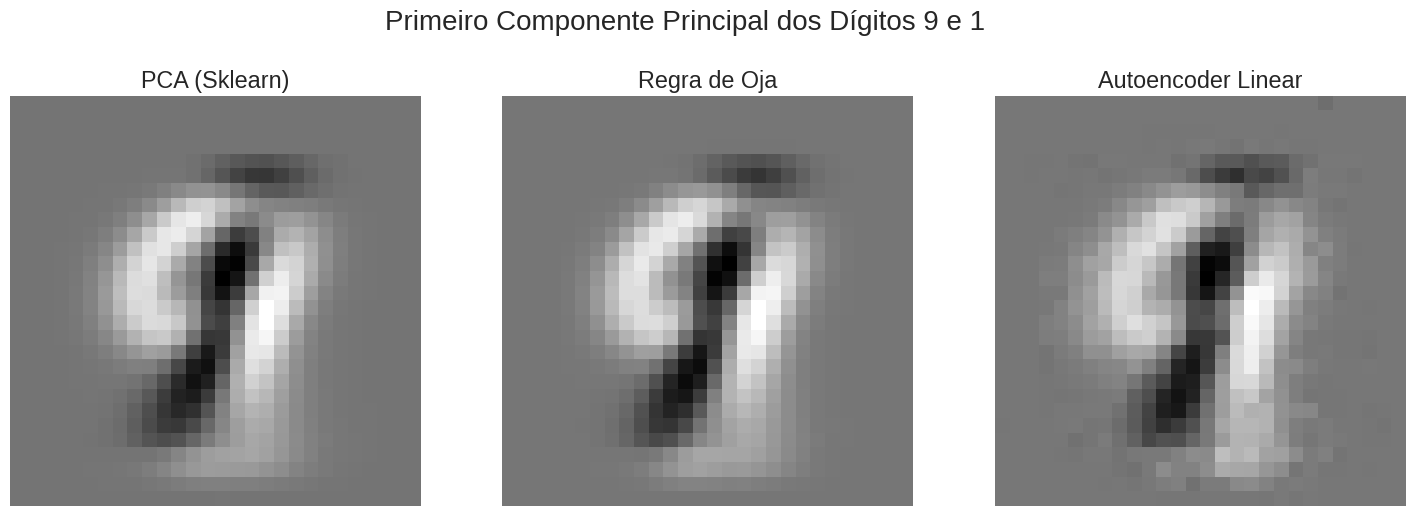

In [ ]:
# Alinhar os vetores (corrigir possível inversão de sinal)
if np.dot(pc1_sklearn, pc1_oja) < 0:
    pc1_oja *= -1

if np.dot(pc1_sklearn, pc1_ae) < 0:
    pc1_ae *= -1

# Função para normalizar e remodelar para exibição
def prep_for_display(pc_vector):
    img = pc_vector.reshape(28, 28)
    # Normalizar para o intervalo [0, 1] para visualização
    img = (img - img.min()) / (img.max() - img.min())
    return img

img_sklearn = prep_for_display(pc1_sklearn)
img_oja = prep_for_display(pc1_oja)
img_ae = prep_for_display(pc1_ae)

# Plotar os resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(img_sklearn, cmap='gray')
axes[0].set_title('PCA (Sklearn)')
axes[0].axis('off')

axes[1].imshow(img_oja, cmap='gray')
axes[1].set_title('Regra de Oja')
axes[1].axis('off')

axes[2].imshow(img_ae, cmap='gray')
axes[2].set_title('Autoencoder Linear')
axes[2].axis('off')

fig.suptitle('Primeiro Componente Principal dos Dígitos 9 e 1', fontsize=20)
plt.show()

### Conclusão

Como podemos ver, os três métodos, apesar de suas formulações muito diferentes (análise de matriz, regra de aprendizado local, otimização de custo global), convergem para a mesma solução fundamental! A imagem resultante representa a "direção" no espaço de 784 pixels que melhor captura a variação entre as imagens de '9' e '1'. As áreas brancas são onde os '1's têm pixels mais intensos, e as áreas escuras são onde os '9's são mais intensos.